# Analyse des causes d’attrition chez TechNova Partners  
## 2. Analyse exploratoire (EDA) & premiers insights

**Objectif :** dégager des différences clés entre les employés ayant quitté l’entreprise et ceux encore en poste, afin de formuler des hypothèses métier avant la phase de modélisation.


## Important : corrélation ≠ causalité

Cette EDA met en évidence des **associations** entre variables et attrition.  
Elle ne prouve pas à elle seule des relations causales.

L’objectif est de :
- détecter des signaux plausibles,
- prioriser des pistes d’investigation RH,
- préparer une modélisation interprétable ensuite (régression logistique + SHAP).


## Chargement du dataset central

Nous réutilisons le dataset central construit dans le notebook 01 (jointure des 3 sources + anonymisation).  
Ce dataset devient la **source unique** pour l’EDA et la suite du projet.


In [1]:
import pandas as pd
import seaborn as sns

from technova_attrition.config import PATHS
from technova_attrition.eda import (
    numeric_group_stats,
    plot_categorical_share,
    plot_numeric_by_target,
    plot_numeric_distribution,
    print_basic_overview,
    require_columns,
    target_distribution,
)

df_path = PATHS.data_processed / "employees_joined.parquet"
df = pd.read_parquet(df_path)

print_basic_overview(df)
df.head()

Shape: (1470, 35)

Columns (first ones):
['age', 'genre', 'revenu_mensuel', 'statut_marital', 'departement', 'poste', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'eval_number', 'note_evaluation_actuelle', 'heure_supplementaires', 'augementation_salaire_precedente', 'eval_number_int', 'a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage', 'distance_domicile_travail', 'niveau_education', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel', 'employee_id_anon']


,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,...,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,employee_id_anon
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,...,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5,emp_02593e2d3346ef8d
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,...,1,2,8,1,Infra & Cloud,Y,Frequent,1,7,emp_6e1ebb9e806c698d
2,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,...,1,4,2,2,Autre,Y,Occasionnel,0,0,emp_db8fbd41f5eb0dcb
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,...,1,5,3,4,Infra & Cloud,Y,Frequent,3,0,emp_dc65e725b0822162
4,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,...,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2,emp_6525529cce69bce2


In [2]:
TARGET = "a_quitte_l_entreprise"
require_columns(df, [TARGET])

target_counts = target_distribution(df, TARGET)
target_counts, (target_counts / target_counts.sum()).round(3)

(a_quitte_l_entreprise
 Non    1233
 Oui     237
 Name: count, dtype: int64,
 a_quitte_l_entreprise
 Non    0.839
 Oui    0.161
 Name: count, dtype: float64)

## Lecture de la distribution de la cible

Nous vérifions si la cible est déséquilibrée (class imbalance).  
C’est un point crucial pour :
- l’interprétation des métriques (accuracy trompeuse),
- le choix des modèles,
- le réglage du seuil de décision (precision/recall tradeoff).


In [3]:
categorical_cols = [
    "genre",
    "statut_marital",
    "departement",
    "poste",
    "domaine_etude",
]

numeric_cols = [
    "age",
    "revenu_mensuel",
    "distance_domicile_travail",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "annees_depuis_la_derniere_promotion",
    "nombre_experiences_precedents",  # si ça plante, on corrigera avec le vrai nom
    "nb_formations_suivies",
    "nombre_participation_pee",
    "nombre_employee_sous_responsabilite",
]

## Analyse des variables qualitatives

Pour des variables qualitatives (genre, statut marital, département, poste…),  
nous utilisons principalement des **barplots** et des **distributions conditionnelles par classe**.

Pourquoi pas des pie charts partout ?
- les barplots comparent mieux les catégories (surtout quand il y en a > 3),
- c’est plus lisible en contexte d’analyse.


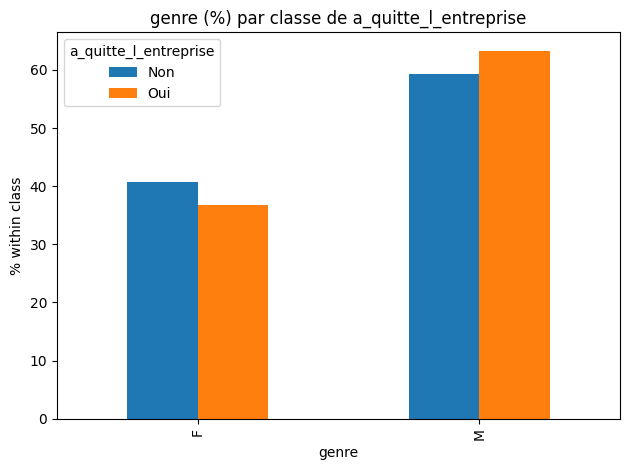

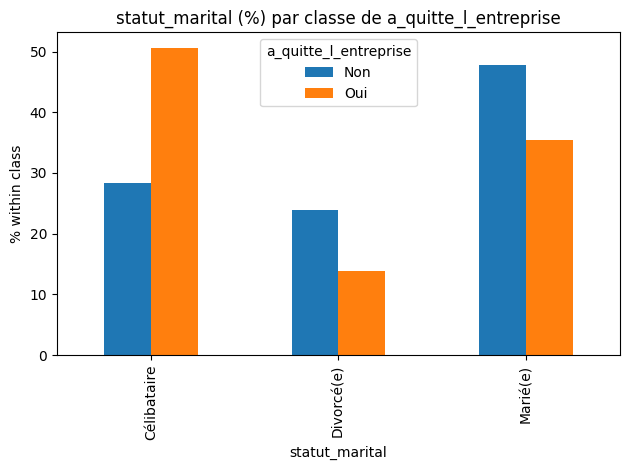

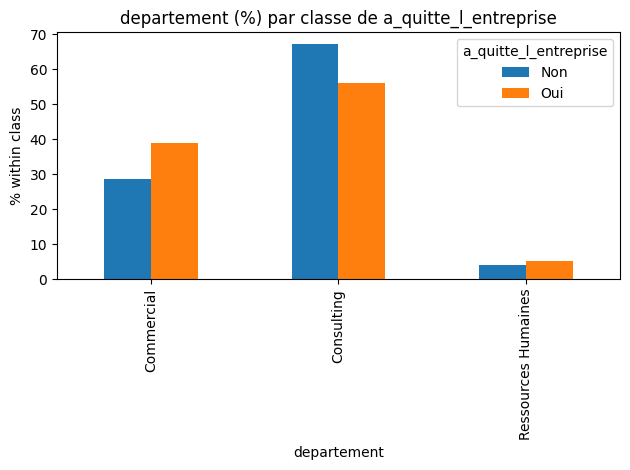

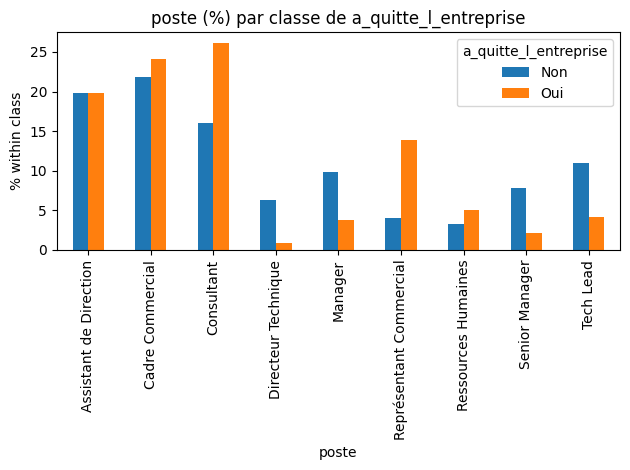

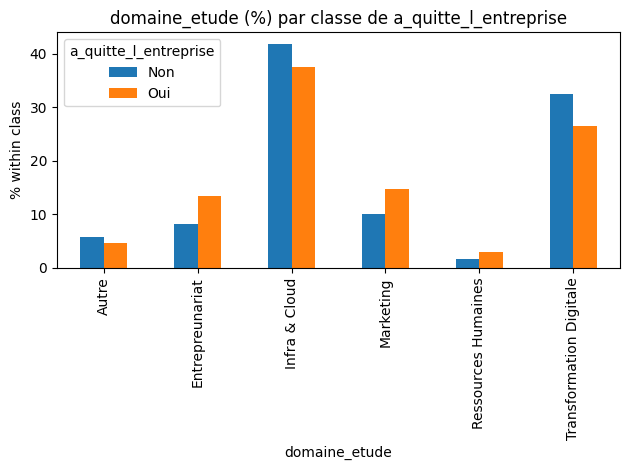

In [4]:
for col in categorical_cols:
    if col in df.columns:
        plot_categorical_share(df, col=col, target=TARGET)

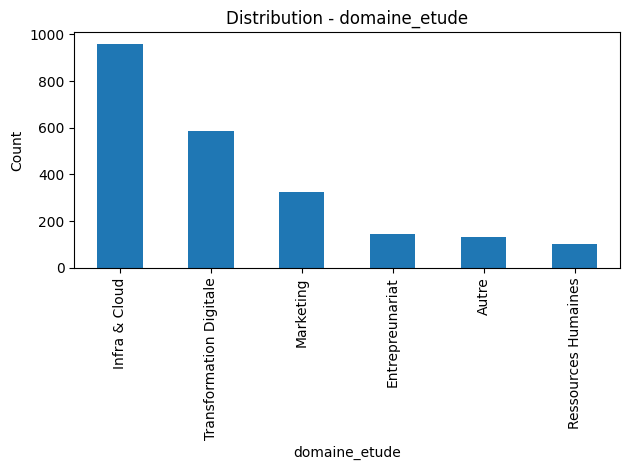

In [5]:
for col in categorical_cols:
    if col in df.columns:
        plot_categorical_share(df, col=col, target=None)

## Analyse des variables quantitatives

Pour les variables quantitatives (âge, salaire, ancienneté…), nous regardons :
- la distribution globale (histogrammes),
- la distribution conditionnelle selon la cible (boxplots)

Cela permet d’identifier des différences potentielles entre les deux populations :
- employés en poste
- employés ayant quitté l’entreprise


G:\Mon Drive\OC\Projet_4\technova_attrition\src\technova_attrition\eda.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


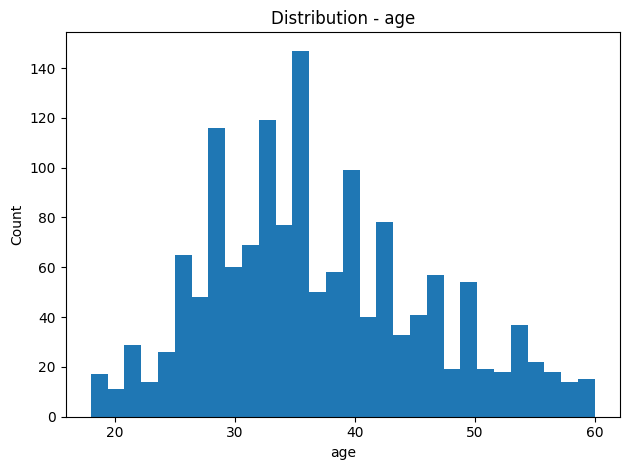

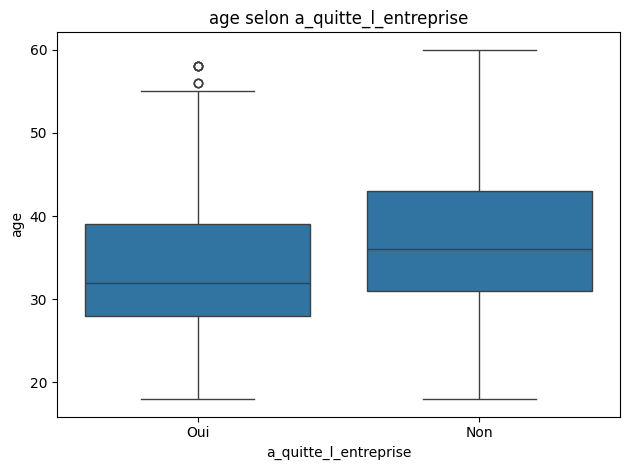

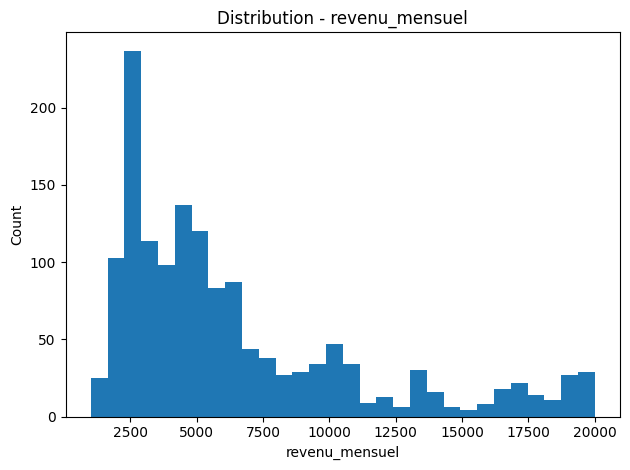

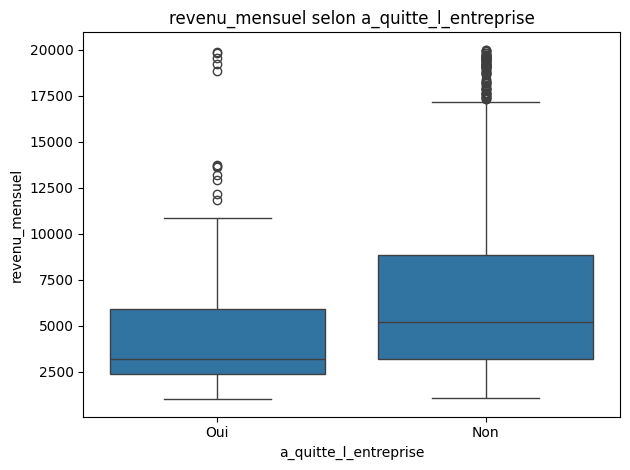

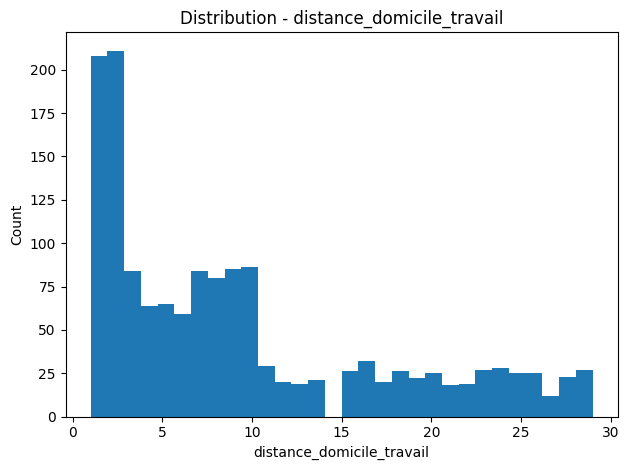

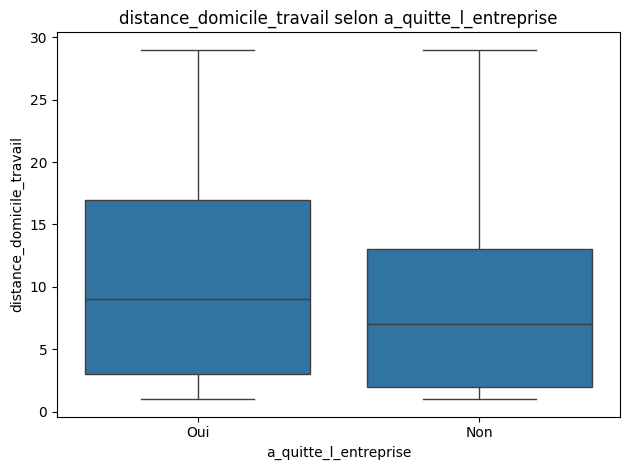

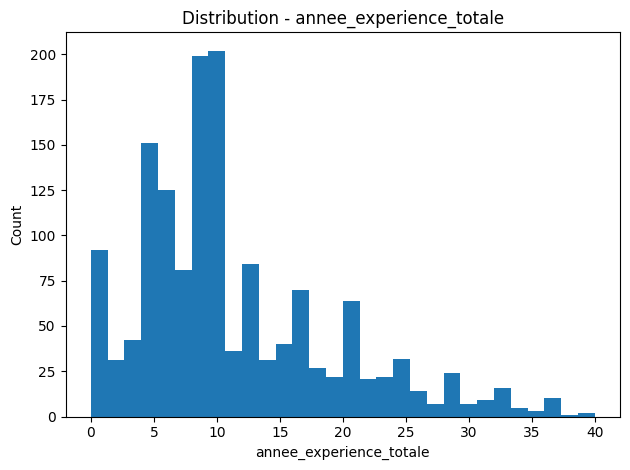

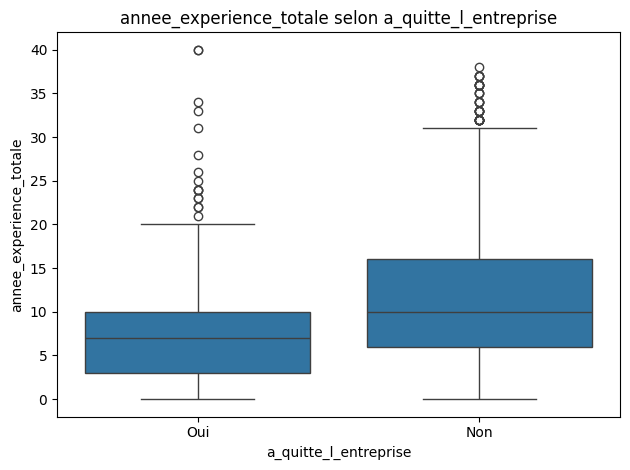

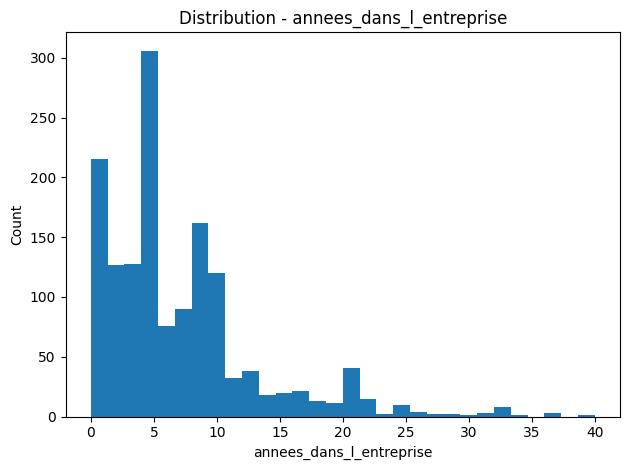

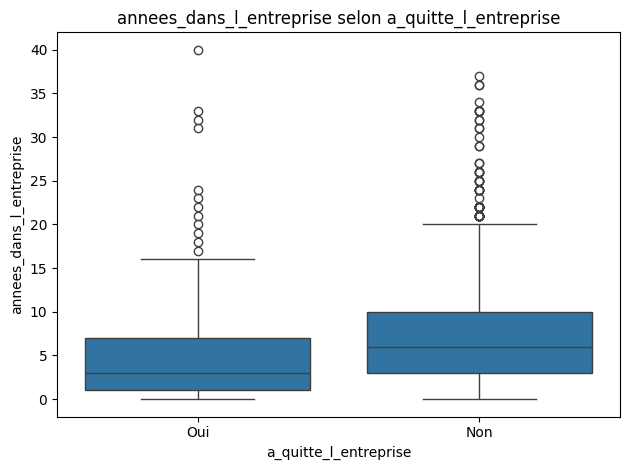

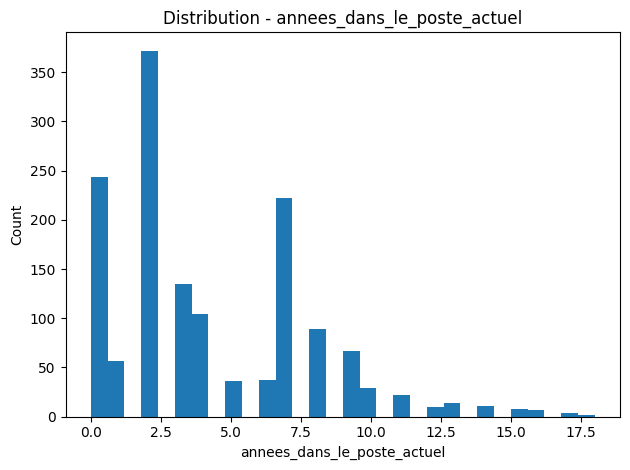

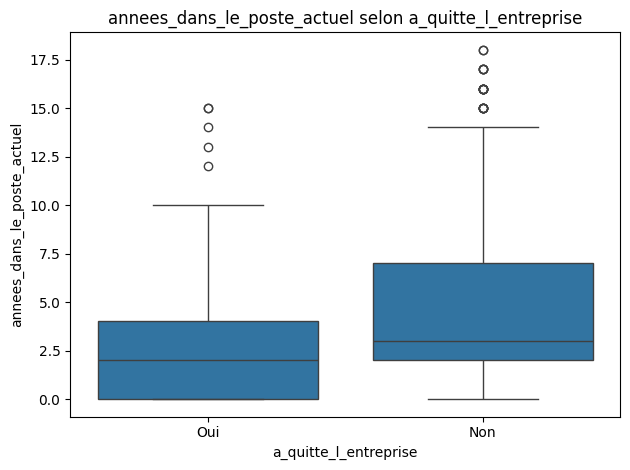

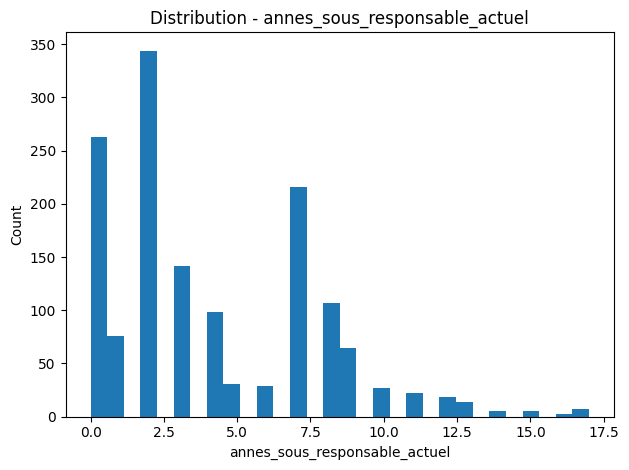

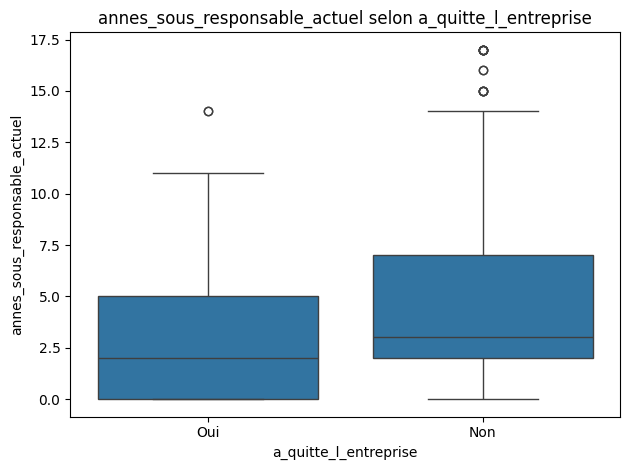

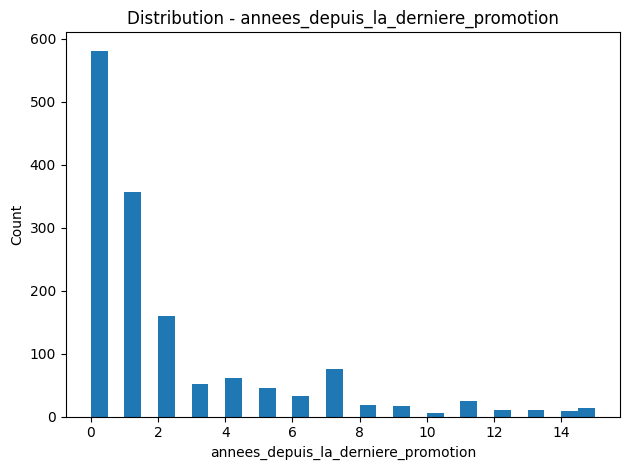

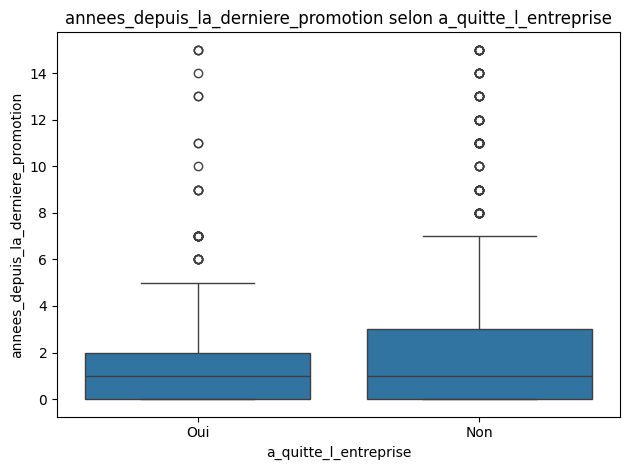

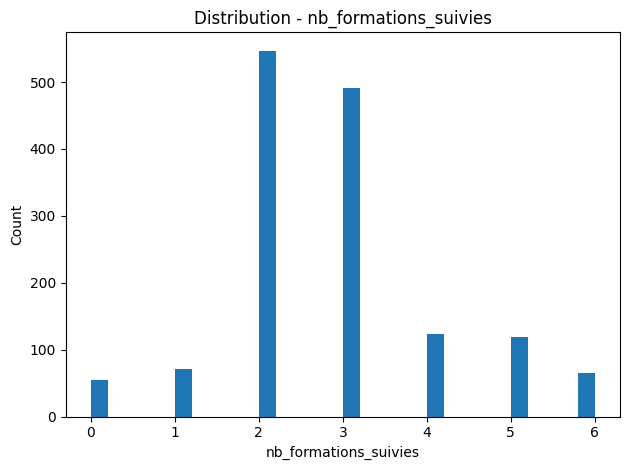

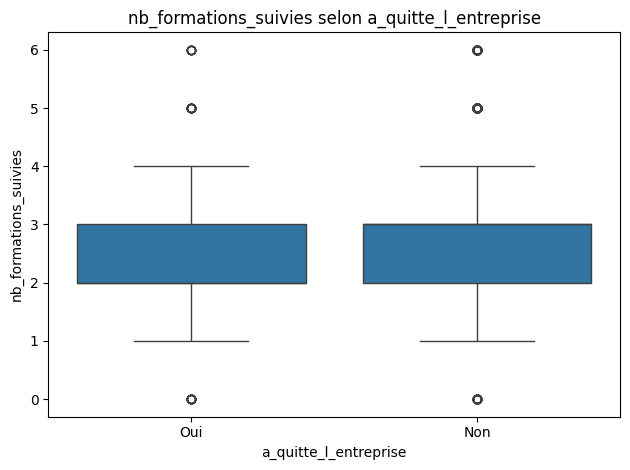

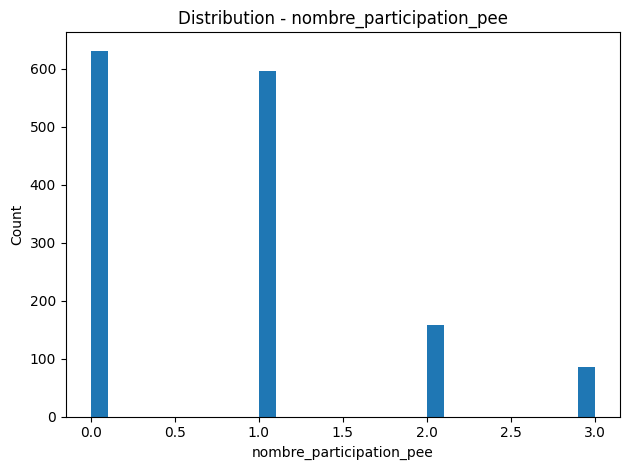

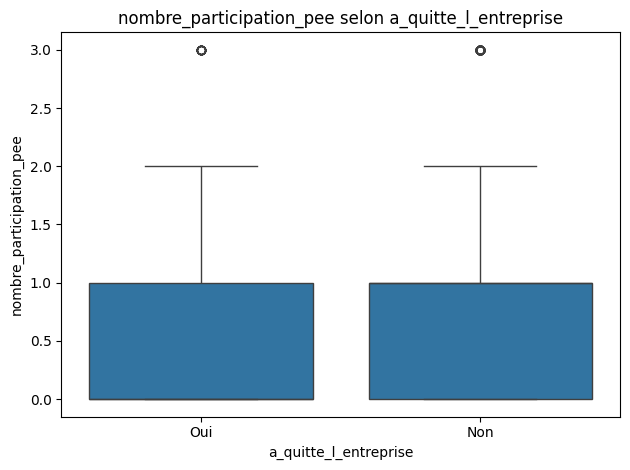

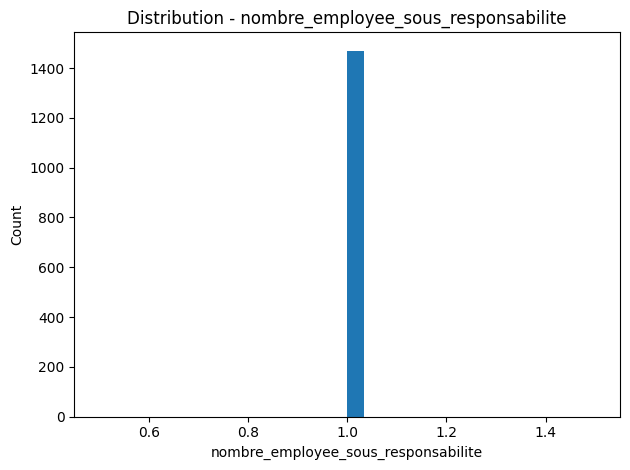

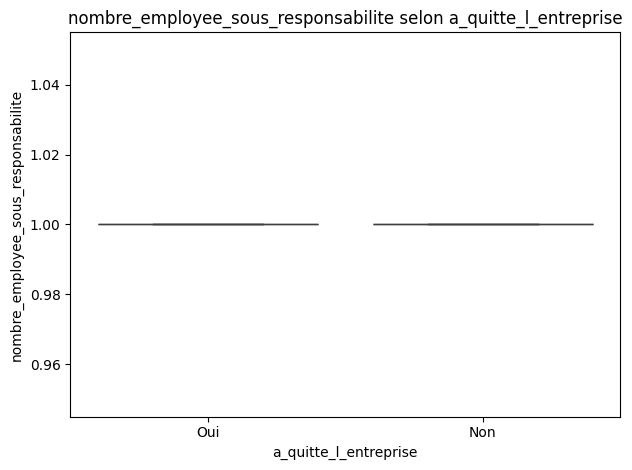

In [6]:
for col in numeric_cols:
    if col in df.columns:
        plot_numeric_distribution(df, col=col, bins=30)
        plot_numeric_by_target(df, col=col, target=TARGET)

## Relations entre variables quantitatives (quanti vs quanti)

Nous analysons ici des relations entre variables quantitatives à l’aide d’un **jointplot** :
- scatter au centre
- distributions marginales (axes)

Exemple : âge vs nombre d’expériences précédentes.


In [7]:
x_col = "age"
y_col = "nombre_experiences_precedents"

if x_col in df.columns and y_col in df.columns:
    sns.jointplot(data=df, x=x_col, y=y_col, kind="scatter")

## Statistiques descriptives par population (attrition vs non-attrition)

Nous calculons des statistiques descriptives par groupe pour repérer rapidement :
- les variables qui “bougent” entre les deux classes
- celles qui semblent peu informatives à ce stade


In [8]:
num_present = [c for c in numeric_cols if c in df.columns]
stats_by_group = numeric_group_stats(df, numeric_cols=num_present, target=TARGET)
stats_by_group

age                                    revenu_mensuel  \
                      count       mean      std median min max          count   
a_quitte_l_entreprise                                                           
Non                    1233  37.561233  8.88836   36.0  18  60           1233   
Oui                     237  33.607595  9.68935   32.0  18  58            237   

                                                         ...  \
                              mean          std  median  ...   
a_quitte_l_entreprise                                    ...   
Non                    6832.739659  4818.208001  5204.0  ...   
Oui                    4787.092827  3640.210367  3202.0  ...   

                      nombre_participation_pee                 \
                                           std median min max   
a_quitte_l_entreprise                                           
Non                                   0.841985    1.0   0   3   
Oui                                   0.856361    0.0   0   3   

                      nombre_employee_sous_responsabilite                   \
                                                    count mean  std median   
a_quitte_l_entreprise                                                        
Non                                                  1233  1.0  0.0    1.0   
Oui                                                   237  1.0  0.0    1.0   

                               
                      min max  
a_quitte_l_entreprise          
Non                     1   1  
Oui                     1   1  

[2 rows x 66 columns]

## Synthèse EDA — premiers enseignements (à confirmer)

À ce stade, nous avons :
- validé la structure et la distribution de la cible (déséquilibre possible),
- observé des différences descriptives entre populations,
- identifié quelques variables candidates à fort pouvoir explicatif (hypothèses).

**Limites :**
- analyses descriptives uniquement,
- pas de causalité,
- nécessité d’une modélisation interprétable et d’une validation robuste (CV, PR-AUC, seuil).
